In [198]:
# !pip install webrtcvad
# !pip install soundfile
# !pip install torchaudio
# !apt-get install libsndfile1
# !pip install librosa
# !pip install numba
# !pip install matplotlib
# !pip install onnxruntime
# !pip install onnx protobuff==3.16.0

In [1]:
import torch
torch.__version__

'1.9.0+cu102'

In [31]:
import webrtcvad
import IPython
import soundfile as sf

import collections
import contextlib
import sys
import wave
import json
import pickle


from os import listdir
from webrtc_utils import *

from soundfile import SoundFile, SEEK_END

from collections import defaultdict
from tqdm import tqdm
import torch.nn as nn

from os import walk
import math
import numpy as np
import librosa

#display waveform
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import torchaudio

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics

In [2]:
vad = webrtcvad.Vad(3)

In [4]:
# Run the VAD on 10 ms of silence. The result should be False.
sample_rate = 16000
frame_duration = 10  # ms
frame = b'\x00\x00' * int(sample_rate * frame_duration / 1000)
vad.is_speech(frame, sample_rate)

False

In [140]:
snr = []
for path in listdir('for_devs'):
    data, samplerate = sf.read('for_devs/'+path) 
    snr.append(signaltonoise_dB(data))

# IPython.display.Audio(data, rate = samplerate)
np.mean(snr)

-58.95451273520077

In [63]:
path = 'output.wav'                                            
data, samplerate = sf.read(path)  

# IPython.display.Audio(data, rate = samplerate)

In [12]:
audio, sample_rate = sf.read(waves['8300-275128-0066.wav'] +'/' + '8300-275128-0066.wav')
IPython.display.Audio(audio, rate = sample_rate)

In [7]:
nonspeech, sample_rate = sf.read('Nonspeech/enc-n76.wav')
IPython.display.Audio(nonspeech, rate = sample_rate)

In [8]:
nonspeech = nonspeech[10000:-2000]

In [37]:
signal = audio

# noise = np.tile(nonspeech, len(signal) // len(nonspeech) + 1)[:len(signal)]
noise = np.pad(nonspeech, (0, len(signal) - len(nonspeech)), 'reflect', reflect_type='even')
noise=get_noise_from_sound(signal,noise,SNR=3)

signal_noise=signal+noise
IPython.display.Audio(signal_noise, rate = sample_rate)

In [103]:
torch_mfcc = torchaudio.transforms.MFCC(sample_rate=sample_rate, n_mfcc=40, melkwargs={'win_length':400, 'hop_length':160, "center":True, 'n_mels':256})

In [3]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [98]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

melspec = librosa.feature.melspectrogram(
  y=audio, sr=sample_rate, n_fft=n_fft,
  win_length=win_length, hop_length=hop_length,
  n_mels=n_mels, htk=True, norm=None)

mfcc_librosa = librosa.feature.mfcc(
  S=librosa.core.spectrum.power_to_db(melspec),
  n_mfcc=n_mfcc, dct_type=2, norm='ortho')


mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }
)

mfcc = mfcc_transform(torch.from_numpy(audio).float())

(40, 1246)


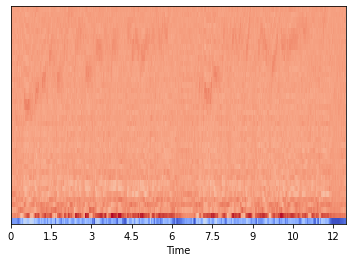

In [88]:
mfccs = librosa.feature.mfcc(audio, sr=sample_rate, win_length=400, hop_length=160, center=True, n_mfcc=40, n_mels = 256)
print(mfccs.shape)
#Displaying  the MFCCs:
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time', hop_length=160)

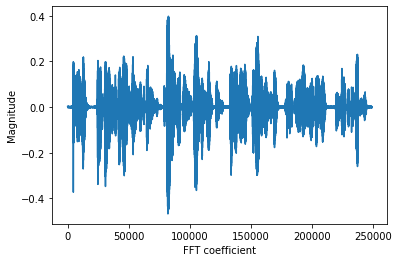

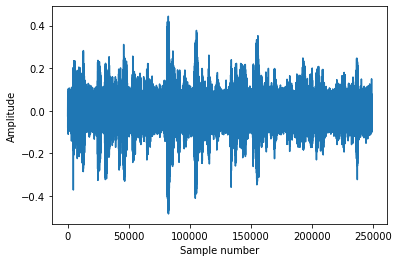

In [78]:
signal = audio
noise=get_white_noise(signal,SNR=3)
plt.plot(signal)
plt.xlabel("FFT coefficient")
plt.ylabel("Magnitude")
plt.show()
signal_noise=signal+noise
plt.plot(signal_noise)
plt.xlabel("Sample number")
plt.ylabel("Amplitude")
plt.show()

In [3]:
def get_white_noise(signal,SNR) :
    #RMS value of signal
    RMS_s=math.sqrt(np.mean(signal**2))
    #RMS values of noise
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    #Additive white gausian noise. Thereore mean=0
    #Because sample length is large (typically > 40000)
    #we can use the population formula for standard daviation.
    #because mean=0 STD=RMS
    STD_n=RMS_n
    noise=np.random.normal(0, STD_n, signal.shape[0])
    return noise

#given a signal, noise (audio) and desired SNR, this gives the noise (scaled version of noise input) that gives the desired SNR
def get_noise_from_sound(signal,noise,SNR):
    RMS_s=math.sqrt(np.mean(signal**2))
    #required RMS of noise
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    
    #current RMS of noise
    RMS_n_current=math.sqrt(np.mean(noise**2))
    noise=noise*(RMS_n/RMS_n_current)
    
    return noise

#***convert complex np array to polar arrays (2 apprays; abs and angle)
def to_polar(complex_ar):
    return np.abs(complex_ar),np.angle(complex_ar)

In [4]:
def signaltonoise_dB(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return 20*np.log10(abs(np.where(sd == 0, 0, m/sd)))

import numpy as np   
def signaltonoise(Arr, axis=0, ddof=0):
    Arr = np.asanyarray(Arr)
    me = Arr.mean(axis)
    sd = Arr.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, me/sd)

In [118]:
path = 'LibriSpeech/train-clean-360/6924/114452/6924-114452-0006.wav'
data, samplerate = sf.read(path)  
audio, sample_rate = read_wave(path)

In [95]:
audio, sample_rate = read_wave(path)
frames = frame_generator(10, audio, sample_rate)
frames = list(frames)

# vad.is_speech(data[:int(sample_rate * frame_duration / 1000)], sample_rate)
# for frame in frames:
#     is_speech = vad.is_speech(frame.bytes, sample_rate)
#     print(is_speech)
    


320


In [5]:
def frame_generator(frame_duration_ms, audio, sample_rate):
    """Generates audio frames from PCM audio data.
    Takes the desired frame duration in milliseconds, the PCM data, and
    the sample rate.
    Yields Frames of the requested duration.
    """
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n <= len(audio):
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n


In [7]:

mypath = 'LibriSpeech'
waves = {}
for (dirpath, dirnames, filenames) in walk(mypath):
    for name in filenames:
        if 'wav' in name:
            waves[name] = dirpath


In [13]:
vad_dict = defaultdict(list)
vad = webrtcvad.Vad(1)
for name, dirpath in tqdm(waves.items()):
    vads = []
    path = dirpath + '/' + name
    audio, sample_rate = read_wave(path)
    
    frames = frame_generator(10, audio, sample_rate)
    frames = list(frames)
    
    for frame in frames:
        is_speech = vad.is_speech(frame.bytes, sample_rate)
        speech = 1 if is_speech else 0
        vads.append(speech)
    vad_dict[name] = vads

100%|██████████| 132553/132553 [25:14<00:00, 87.54it/s] 


In [15]:
from sklearn.model_selection import train_test_split
dev_samples = {}
train_samples = {}

keys_array = np.array(list(vad_dict.keys()))

# train_keys, dev_keys = train_test_split(keys_array, test_size=0.2)
dev_keys = listdir('test')

# for key in train_keys:
#     train_samples[key] = vad_dict[key]
for key in dev_keys:
    dev_samples[key] = vad_dict[key]
train_samples = {}
for i in vad_dict:
    if i not in dev_samples:
        train_samples[i] = vad_dict[i]

In [16]:
import json
import pickle

# with open('vads.json', 'w') as f:
#     json.dump(vad_dict, f)
    
# with open('train.pkl', 'wb') as f:
#     pickle.dump(train_samples, f, pickle.HIGHEST_PROTOCOL)    
    
# with open('dev.pkl', 'wb') as f:
#     pickle.dump(dev_samples, f, pickle.HIGHEST_PROTOCOL)   
    
# with open('all.pkl', 'wb') as f:
#     pickle.dump(vad_dict, f, pickle.HIGHEST_PROTOCOL)  

In [27]:
with open('train.pkl', 'rb') as f:
    train_samples = pickle.load(f)    
    
with open('dev.pkl', 'rb') as f:
    dev_samples = pickle.load(f) 

In [11]:
import random

dev_mfccs = []
nonspeech_dict = {}
for i in listdir('Nonspeech'):
    if 'enc' in i:
        path = 'Nonspeech/' + i
        signal, samplerate = sf.read(path)
        nonspeech_dict[i] = signal

# for key in tqdm(dev_samples):
#     path = waves[key] + '/' + key
#     signal, samplerate = sf.read(path)
#     a = random.random()
#     if a < 0.2:
#         # white noise
#         noise = get_white_noise(signal, SNR=3)
#         signal_noise = signal + noise
#         sf.write('test/' + key, signal_noise, samplerate)
#     else:
#         # real world noise
#         b = random.randint(1,100)
#         nonspeech_key = 'enc-n' + str(b) + '.wav'
#         nonspeech = nonspeech_dict[nonspeech_key][10000:-2000]
#         if len(signal) > len(nonspeech):
#             noise = np.pad(nonspeech, (0, len(signal) - len(nonspeech)), 'reflect', reflect_type='even')[:len(signal)]
#         else:
#             noise = nonspeech[:len(signal)]
#         noise = get_noise_from_sound(signal, noise, SNR=3)
#         signal_noise=signal+noise
#         sf.write('test/' + key, signal_noise, samplerate)
    

In [279]:
name_wav = '5635-44582-0001.wav'
target = vad_dict[name_wav]
path = 'test' + '/' + name_wav
audio, sample_rate = read_wave(path)
vad = webrtcvad.Vad(1)

frames = frame_generator(10, audio, sample_rate)
frames = list(frames)
pred = []

for frame in frames:
    is_speech = vad.is_speech(frame.bytes, sample_rate)
    speech = 1 if is_speech else 0
    pred.append(speech)
    


In [280]:
from sklearn.metrics import classification_report

print(classification_report(target, pred))

              precision    recall  f1-score   support

           0       0.90      0.30      0.45       369
           1       0.82      0.99      0.89      1149

    accuracy                           0.82      1518
   macro avg       0.86      0.65      0.67      1518
weighted avg       0.84      0.82      0.79      1518



In [322]:
# vad_dict = defaultdict(list)
preds = []
targets = []
vad = webrtcvad.Vad(1)
for name in tqdm(listdir('test')[:10000]):
    vads = []
    path = 'test' + '/' + name
    audio, sample_rate = read_wave(path)
    target = dev_samples[name]
    targets.extend(target)
    
    frames = frame_generator(10, audio, sample_rate)
    frames = list(frames)
    
    for frame in frames:
        is_speech = vad.is_speech(frame.bytes, sample_rate)
        speech = 1 if is_speech else 0
        vads.append(speech)
    preds.extend(vads)
#     print(len(target), len(preds), name, len(frames))
#     break
    

100%|██████████| 10000/10000 [03:05<00:00, 54.05it/s]


In [323]:
from sklearn.metrics import classification_report

print(classification_report(targets, preds))

              precision    recall  f1-score   support

           0       0.45      0.24      0.31   1167129
           1       0.93      0.97      0.95  11448449

    accuracy                           0.90  12615578
   macro avg       0.69      0.60      0.63  12615578
weighted avg       0.88      0.90      0.89  12615578



In [119]:
import random

train_X = []
train_Y = []
for key in tqdm(list(train_samples.keys())[:50000]):
    path = waves[key] + '/' + key
    signal, samplerate = sf.read(path)
    
    target = np.array(train_samples[key])
    train_Y.append(target)
    
    a = random.random()
    if a < 0.2:
        # white noise
        noise = get_white_noise(signal, SNR=3)
        signal_noise = signal + noise
    else:
        # real world noise
        b = random.randint(1,100)
        nonspeech_key = 'enc-n' + str(b) + '.wav'
        nonspeech = nonspeech_dict[nonspeech_key][10000:-2000]
        if len(signal) > len(nonspeech):
            noise = np.pad(nonspeech, (0, len(signal) - len(nonspeech)), 'reflect', reflect_type='even')[:len(signal)]
        else:
            noise = nonspeech[:len(signal)]
        snr = random.randint(-3, 3)
        noise = get_noise_from_sound(signal, noise, SNR=snr)
        signal_noise = signal + noise
    mfcc = audio_transforms(torch.from_numpy(signal_noise).float())[:,:-1].transpose(0, 1)
#     mfccs = librosa.feature.mfcc(signal_noise, sr=samplerate, win_length=320, hop_length=160, n_mfcc=40)[:, :-1]
    train_X.append(mfcc)
# train_X = np.array(train_X)
# train_Y = np.array(train_Y)

    

100%|██████████| 50000/50000 [11:47<00:00, 70.71it/s] 


In [13]:
import pickle

with open('train_X.pkl', 'wb') as f:
    pickle.dump(train_X, f)

In [16]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self,sample, target):
        self.samples = sample
        self.targets = target
        

    def __getitem__(self, n):
        return self.samples[n].float(), torch.from_numpy(self.targets[n]).float()

    def __len__(self):
        return len(self.samples)

In [112]:
# audio_transforms = torchaudio.transforms.MFCC(sample_rate=16000, n_mfcc=40, melkwargs={'win_length':400, 'hop_length':160, "center":True, 'n_mels':64}) # n_mels = 64
audio_transforms = nn.Sequential(
    torchaudio.transforms.MFCC(sample_rate=16000, n_mfcc=40, melkwargs={'win_length':400, 'hop_length':160, "center":True, 'n_mels':64}),
    torchaudio.transforms.SlidingWindowCmn(cmn_window=600, norm_vars=True, center=True)
)
train_audio_transforms = nn.Sequential(
#     torchaudio.transforms.SlidingWindowCmn(cmn_window=600, norm_vars=True, center=True),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=3),
#     torchaudio.transforms.TimeMasking(time_mask_param=3)
)


def data_processing(data):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for waveform, target in data:
#         spec = audio_transforms(waveform)[:,:-1].transpose(0, 1)
#         if data_type == 'train':
#             spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
#         else:
#             spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spec = train_audio_transforms(waveform)
        spectrograms.append(spec)
        labels.append(target)
#         input_lengths.append(spec.shape[0]//2)
#         label_lengths.append(len(label))
    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels

In [146]:
import torch.nn as nn
import torch.nn.functional as F

class LSTMModel(nn.Module):
    def __init__(self, inpud_dim=40, hidden_dim=64, n_layers=2, dropout=0.5):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(inpud_dim, hidden_dim, num_layers=n_layers, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_dim)

        self.fc1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc2 = nn.Linear(hidden_dim//2, 1)
        self.dropout1 = nn.Dropout(dropout)
        
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
#         x = self.layer_norm(x)
        x, _ = self.lstm(x)
#         x = self.layer_norm(x)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        
        return x
    
class FeedForwardModel(nn.Module):
    def __init__(self, inpud_dim=40, hidden_dim=64, dropout=0.5):
        super(FeedForwardModel, self).__init__()

        self.fc1 = nn.Linear(inpud_dim, hidden_dim)
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.layer_norm2 = nn.LayerNorm(hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, 1)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
    

    def forward(self, x):
        x = self.fc1(x)
        x = self.layer_norm1(x)
        x = F.leaky_relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.layer_norm2(x)
        x = F.leaky_relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x
model = LSTMModel().float()
# model = FeedForwardModel().float()

In [142]:
trainModel(model, train_X[:50000], train_Y[:50000], 'checkpoints_new/', lr=1e-3, EPOCHS=30, batch_size=128, device='cuda', each=10, step_size=5)

epochs:   0%|          | 0/30 [00:00<?, ?it/s]

DATASET SIZE: 50000
START TRAINING


epochs: 100%|██████████| 30/30 [27:18<00:00, 54.62s/it, train=0.1]  


In [116]:
import torch.utils.data as data_utils
import os
from datetime import datetime
def trainModel(model, X, y, checkpoints_path, lr=1e-3, EPOCHS=10, batch_size=64, device='cuda', each=20, step_size=5, class_weight=[0.65, 0.35]):
    
    model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = torch.nn.BCELoss()
    
    scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=step_size, gamma=0.1)
    last_epoch = -1
    
    train_dataset = CustomDataset(X, y)
    use_cuda = device == 'cuda'
    kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}

    print('DATASET SIZE: {}'.format(len(train_dataset)))
    
    model.train()
    iterator = tqdm(range(EPOCHS), desc='epochs')
    print('START TRAINING')
    
    for epoch in iterator:
        try:
            if epoch <= last_epoch:
                continue

            train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    collate_fn=lambda x: data_processing(x),
                                    **kwargs)

            mean_loss = 0
            for batch_x, batch_y in train_loader:
                optim.zero_grad()
                batch_x = batch_x.float().to(device)
                batch_y = batch_y.reshape(batch_y.shape[0], -1, 1).to(device)

                output = model(batch_x)
                loss = loss_function(output, batch_y)

                loss.backward()
                optim.step()


                mean_loss += loss.detach().cpu().item()*len(batch_x)
            mean_loss /= len(train_dataset)
            scheduler.step()


            if epoch != 0 and epoch % each == 0:
                check_path = os.path.join(checkpoints_path, 'model_checpoint{}'.format(datetime.now().strftime("_%Y%m%d_%H%M%S")) + '.pt')
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': mean_loss,
                    }, check_path)
            iterator.set_postfix({'train': mean_loss})
        except KeyboardInterrupt:
            PATH = os.path.join(checkpoints_path, 'model_checpoint{}'.format(datetime.now().strftime("_%Y%m%d_%H%M%S")) + '_{}'.format(epoch) + '.pt')
            torch.save(model.state_dict(), PATH)
            return
   

In [149]:
model = LSTMModel().float()
# model = FeedForwardModel().float()
model.load_state_dict(torch.load('checkpoints_new/lstm_model.pt')['model_state_dict'])
model.eval()

LSTMModel(
  (lstm): LSTM(40, 64, num_layers=2, batch_first=True)
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [125]:
def testModel(model, max_samples=10000, device='cuda'):
    
    model.to(device)
    test_y = []
    test_X = []
    for key in tqdm(listdir('test/')[:max_samples]):
        path = 'test/' + key
        target = np.array(dev_samples[key])
        signal, samplerate = sf.read(path)
        
        
        mfcc = audio_transforms(torch.from_numpy(signal).float())[:,:-1].transpose(0, 1)
        test_X.append(mfcc)
        test_y.append(target)
    
    
    test_dataset = CustomDataset(test_X, test_y)
    use_cuda = device == 'cuda'
    kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}

    print('DATASET SIZE: {}'.format(len(test_dataset)))
    
    model.eval()
    preds = []
    for x, _ in tqdm(test_dataset):
        
        with torch.no_grad():
            output = model(torch.unsqueeze(x, 0).float().to(device))
            pred = output.cpu().detach().numpy()
            preds.extend(pred)
    
    return test_y, preds

    

In [150]:
target, pred = testModel(model, max_samples=1000)

  0%|          | 3/1000 [00:00<00:34, 28.87it/s]

DATASET SIZE: 1000


100%|██████████| 1000/1000 [00:19<00:00, 50.61it/s]


In [215]:
pred[0].shape

(1185, 1)

In [29]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics

In [239]:
tmp_pred = np.vstack(pred).squeeze(1) > 0.7
print(classification_report(np.hstack(target), tmp_pred.astype(int)))

              precision    recall  f1-score   support

           0       0.58      0.94      0.72    115921
           1       0.99      0.93      0.96   1150638

    accuracy                           0.93   1266559
   macro avg       0.79      0.93      0.84   1266559
weighted avg       0.96      0.93      0.94   1266559



In [238]:
tmp_pred = np.vstack(pred).squeeze(1) > 0.72
print(classification_report(np.hstack(target), tmp_pred.astype(int)))

              precision    recall  f1-score   support

           0       0.57      0.94      0.71    115921
           1       0.99      0.93      0.96   1150638

    accuracy                           0.93   1266559
   macro avg       0.78      0.94      0.84   1266559
weighted avg       0.96      0.93      0.94   1266559



In [235]:
roc_auc_score(np.hstack(target), np.vstack(pred).squeeze(1))

0.9730833803121421

In [234]:
fpr, tpr, thresholds = roc_curve(np.hstack(target), np.vstack(pred).squeeze(1))
thresholds

array([2.        , 1.        , 0.9999999 , ..., 0.06354877, 0.06235618,
       0.04908296], dtype=float32)

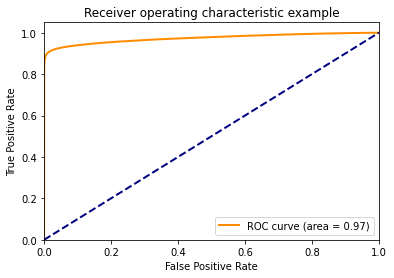

In [232]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
# for i in range(1):
#     fpr[i], tpr[i], _ = roc_curve(np.hstack(target), np.vstack(pred).squeeze(1))
#     roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr, tpr, _ = roc_curve(np.hstack(target), np.vstack(pred).squeeze(1))
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Best Threshold=0.904511, G-Mean=0.946


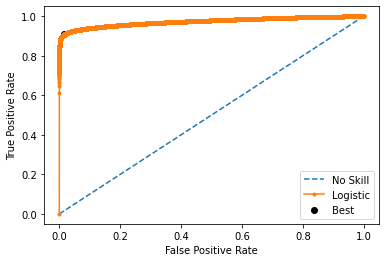

In [236]:
from matplotlib import pyplot
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [231]:
ix

NameError: name 'ix' is not defined

In [385]:
tmp_pred = np.vstack(pred).squeeze(1) > 0.5
print(classification_report(np.hstack(target), tmp_pred.astype(int)))

              precision    recall  f1-score   support

           0       0.64      0.65      0.65     12879
           1       0.96      0.96      0.96    119185

    accuracy                           0.93    132064
   macro avg       0.80      0.81      0.80    132064
weighted avg       0.93      0.93      0.93    132064



In [389]:
from sklearn.metrics import classification_report


tmp_pred = np.vstack(pred).squeeze(1) > 0.87
print(classification_report(np.hstack(target), tmp_pred.astype(int)))

              precision    recall  f1-score   support

           0       0.48      0.97      0.65     12879
           1       1.00      0.89      0.94    119185

    accuracy                           0.90    132064
   macro avg       0.74      0.93      0.79    132064
weighted avg       0.95      0.90      0.91    132064



In [91]:
tmp_pred[tmp_pred > 0.999]

array([0.99985623, 0.99998784, 0.99999964, ..., 0.9997665 , 0.999671  ,
       0.9991874 ], dtype=float32)

In [166]:
grid = np.arange(0, 1.01, 0.01)
tmp_pred = np.vstack(pred).squeeze(1)
tmp_target = np.hstack(target)
far = []
frr = []
for thr in grid:
    mask = tmp_pred > thr
    fa = np.count_nonzero((mask.astype(int) != tmp_target) & (mask.astype(int) == 1))
    far.append(fa / (fa +  np.count_nonzero((mask.astype(int) == tmp_target) & (mask.astype(int) == 0))))
    
    fr = np.count_nonzero((mask.astype(int) != tmp_target) & (mask.astype(int) == 0))
#     print(fr, (fr +  np.count_nonzero((mask.astype(int) == tmp_target) & (mask.astype(int) == 1))))
    frr.append(fr / (fr +  np.count_nonzero((mask.astype(int) == tmp_target) & (mask.astype(int) == 1))))
far = np.array(far) 
frr = np.array(frr)
#     print(fa, np.count_nonzero(tmp_target == 0))
for i, thr in enumerate(grid):
    if np.abs(far[i] - frr[i]) < 0.005:
#         print(far[i], thr)
        eer = far[i]
        eer_thr = thr

In [182]:
grid[frr < 0.1].max(), grid[far < 0.1].min(), eer_thr, eer * 100

(0.9400000000000001, 0.63, 0.7000000000000001, 6.420752063905591)

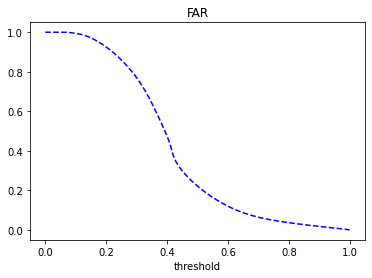

In [169]:
plt.plot(grid, far,'--b')
plt.xlabel('threshold')
plt.title('FAR')
plt.show()

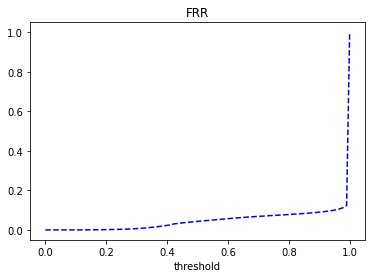

In [170]:
plt.plot(grid,frr,'--b')
plt.xlabel('threshold')
plt.title('FRR')
plt.show()

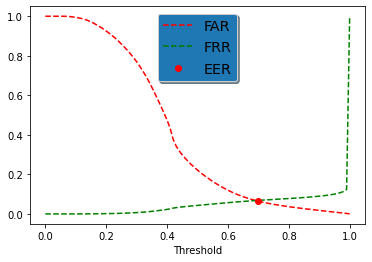

In [171]:
fig, ax = plt.subplots()

ax.plot(grid, far, 'r--', label='FAR')
ax.plot(grid, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
plt.plot(eer_thr, eer,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

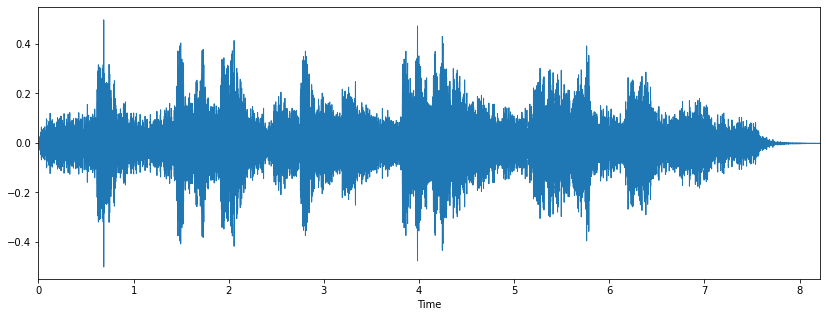

In [358]:
#display waveform
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(data, sr=samplerate)

In [184]:
train_X[0].shape

torch.Size([394, 40])

In [ ]:
import torch.onnx

In [207]:
# Input to the model
batch_size = 1
x = torch.randn(batch_size, 394, 40, requires_grad=False)
model.cpu()
model.eval()
torch_out = model(x)

# Export the model
torch.onnx.export(model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "vad.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size', 1: 'audio_length'},    # variable length axes
                                'output' : {0 : 'batch_size', 1: 'audio_length'}})

In [208]:
import onnx

onnx_model = onnx.load("vad.onnx")
onnx.checker.check_model(onnx_model)

In [196]:
import onnxruntime

In [211]:
ort_session = onnxruntime.InferenceSession("vad.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

In [242]:
train_X[0].shape

torch.Size([394, 40])

In [218]:
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(torch.unsqueeze(train_X[0], 0))}
ort_outs = ort_session.run(None, ort_inputs)

In [245]:
ort_outs[0].reshape(train_X[0].shape[0])

array([0.652763  , 0.6113671 , 0.6211816 , 0.62072426, 0.62276363,
       0.60732037, 0.5607207 , 0.5686276 , 0.5432571 , 0.5369395 ,
       0.546793  , 0.5585627 , 0.555642  , 0.5272734 , 0.5121541 ,
       0.517239  , 0.5178488 , 0.49846143, 0.48049545, 0.4809013 ,
       0.48048535, 0.49012917, 0.4935458 , 0.46330172, 0.46418953,
       0.48660523, 0.47381562, 0.4463991 , 0.44901338, 0.44394585,
       0.4536907 , 0.47200578, 0.581136  , 0.96580976, 0.9995197 ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.9999999 , 0.9999999 , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [ ]:
def process_audio(wave):
    audio_transforms = nn.Sequential(
        torchaudio.transforms.MFCC(sample_rate=16000, n_mfcc=40,
                                   melkwargs={'win_length': 400, 'hop_length': 160, "center": True, 'n_mels': 64}),
        torchaudio.transforms.SlidingWindowCmn(cmn_window=300, norm_vars=True, center=True)
    )
    mfcc = audio_transforms(torch.from_numpy(wave).float())[:, :-1].transpose(0, 1)
    return mfcc

In [ ]:
thr = 0.7
output_text = ""
for filename in tqdm(listdir('for_devs')):
    data, samplerate = sf.read('for_devs/' + filename)
    features = process_audio(data)
    
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(torch.unsqueeze(features, 0))}
    ort_outs = ort_session.run(None, ort_inputs)
    output = ort_outs[0].reshape(features.shape[0])

    output = (output > thr).astype(int)
    output_text += filename + ',' + ','.join(map(str, output.tolist())) + '\n'

with open('pred_for_devs.csv', 'w') as file:
    file.write(output_text)